# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm import tqdm
from scipy.stats import ranksums

In [2]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [3]:
! ls 

HW1-DESeq2.csv              getRNASeq_data.R
HW1-GSE62944-clinical.csv   hw1.ipynb
HW1-GSE62944-count.csv      test.ipynb
HW1_CSCI5461_Spring2023.pdf


# Exploring the dataset

In [4]:
genes = pd.read_csv("HW1-GSE62944-count.csv", index_col=0)
print(f"There are {genes.shape[0]} genes and {genes.shape[1]} samples")
genes

There are 23368 genes and 154 samples


,TCGA-02-2483-01A-01R-1849-01,TCGA-02-2485-01A-01R-1849-01,TCGA-02-2486-01A-01R-1849-01,TCGA-06-0129-01A-01R-1849-01,TCGA-06-0178-01A-01R-1849-01,TCGA-06-0184-01A-01R-1849-01,TCGA-06-0644-01A-02R-1849-01,TCGA-06-0645-01A-01R-1849-01,TCGA-06-0646-01A-01R-1849-01,TCGA-06-0686-01A-01R-1849-01,...,TCGA-32-1980-01A-01R-1850-01,TCGA-32-2615-01A-01R-1850-01,TCGA-32-2616-01A-01R-1850-01,TCGA-32-2632-01A-01R-1850-01,TCGA-41-2571-01A-01R-1850-01,TCGA-41-2572-01A-01R-1850-01,TCGA-41-4097-01A-01R-1850-01,TCGA-76-4927-01A-01R-1850-01,TCGA-76-4928-01B-01R-1850-01,TCGA-76-4931-01A-01R-1850-01
1/2-SBSRNA4,51,35,26,93,144,34,48,30,103,17,...,39,71,27,42,73,42,52,29,55,65
A1BG,784,162,203,373,2048,280,598,442,508,308,...,385,956,861,203,1204,1189,303,274,273,114
A1BG-AS1,51,27,25,96,49,21,46,41,67,18,...,87,125,99,22,101,85,55,21,22,28
A1CF,1,1,1,4,3,1,3,2,2,4,...,2,4,2,1,7,2,2,1,2,2
A2LD1,91,319,339,129,79,272,402,184,418,123,...,248,277,520,433,114,454,172,240,210,304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,3125,2491,1258,4043,1773,1675,1573,1887,2405,877,...,2873,2335,2838,1581,2001,2139,1345,1527,2314,2833
ZYX,14291,12796,15071,11782,5350,19715,38265,30441,19149,10046,...,9985,16278,62673,9951,14345,30473,7891,12706,51102,20501
ZZEF1,2229,2688,1210,5602,565,1477,2172,2351,4472,994,...,2253,3624,2550,1990,3670,2007,2592,2106,3036,4219
ZZZ3,1835,1660,1029,3125,1014,1302,1699,1090,1473,614,...,1237,1908,2525,1002,613,775,946,888,1462,1497


In [5]:
outcomes = pd.read_csv("HW1-GSE62944-clinical.csv", index_col=[0, 1])
outcomes.index = outcomes.index.get_level_values(1)
print(outcomes["Group"].value_counts())
outcomes

long     78
short    76
Name: Group, dtype: int64


,Group
sampleName,
TCGA-02-2483-01A-01R-1849-01,short
TCGA-02-2485-01A-01R-1849-01,short
TCGA-02-2486-01A-01R-1849-01,short
TCGA-06-0129-01A-01R-1849-01,short
TCGA-06-0178-01A-01R-1849-01,short
...,...
TCGA-41-2572-01A-01R-1850-01,long
TCGA-41-4097-01A-01R-1850-01,long
TCGA-76-4927-01A-01R-1850-01,long


# Data processing and normalization

In [6]:
sums = genes.sum(axis=0)
sums

TCGA-02-2483-01A-01R-1849-01    48043679
TCGA-02-2485-01A-01R-1849-01    44134155
TCGA-02-2486-01A-01R-1849-01    40487411
TCGA-06-0129-01A-01R-1849-01    48705189
TCGA-06-0178-01A-01R-1849-01    34946116
                                  ...   
TCGA-41-2572-01A-01R-1850-01    37409173
TCGA-41-4097-01A-01R-1850-01    29974755
TCGA-76-4927-01A-01R-1850-01    29793712
TCGA-76-4928-01B-01R-1850-01    56535122
TCGA-76-4931-01A-01R-1850-01    46754015
Length: 154, dtype: int64

Text(0.5, 0, 'Rank (sample)')

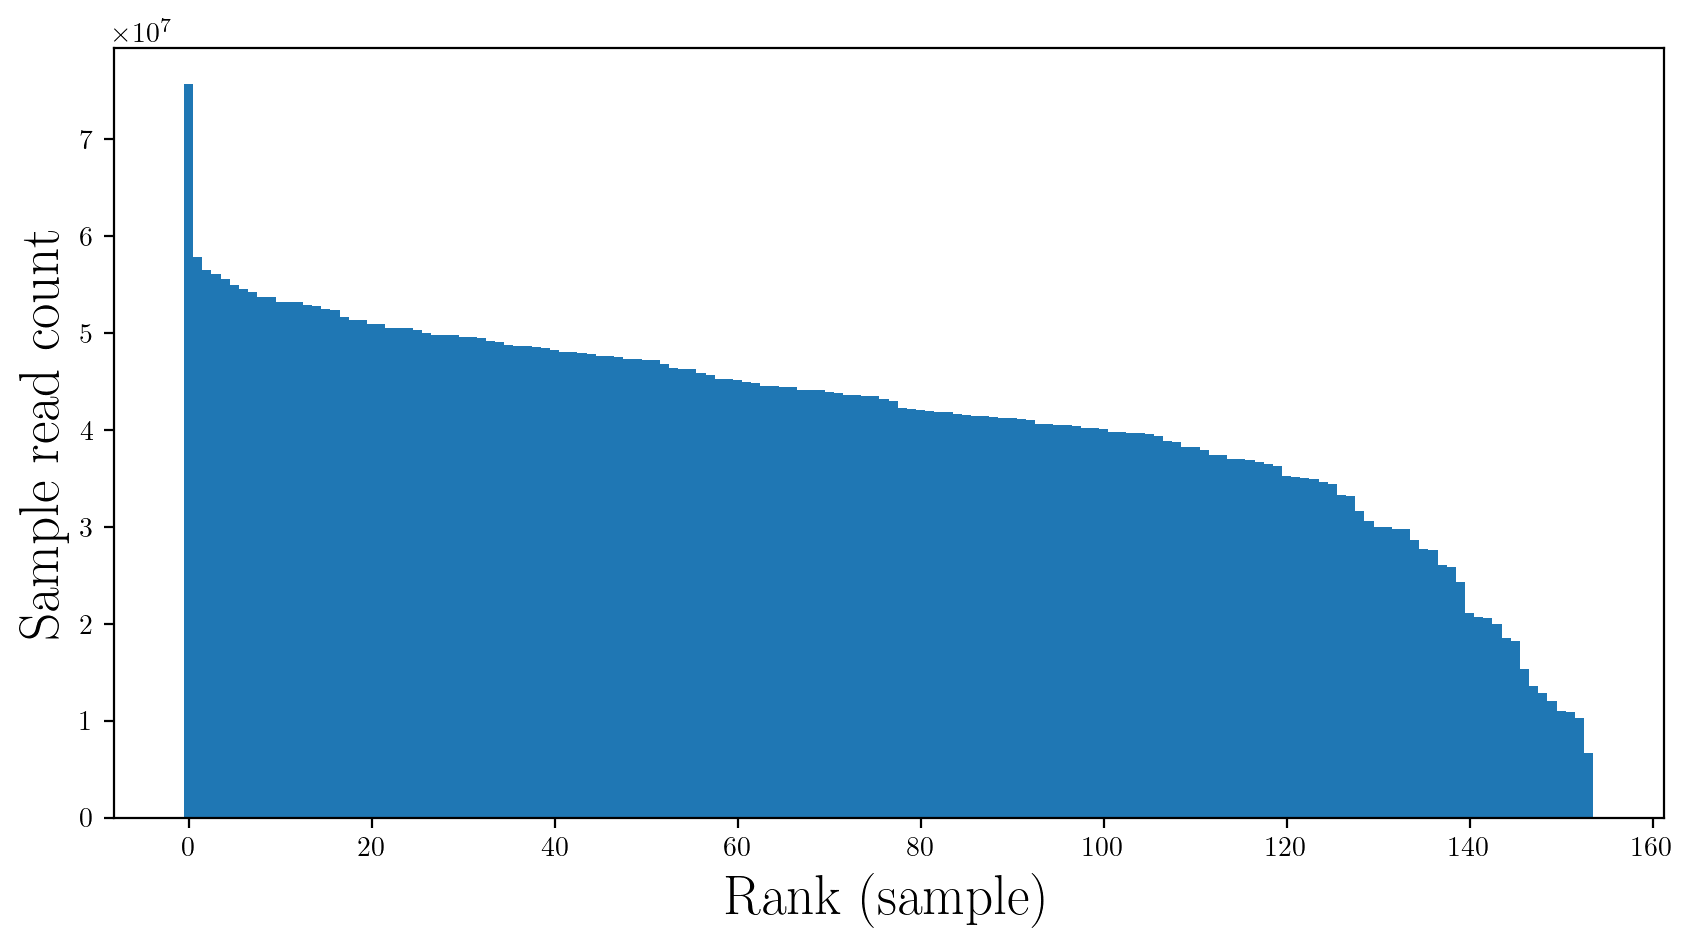

In [7]:
plt.figure(figsize=(10, 5), dpi=200)
plt.bar(range(sums.shape[0]), sums.sort_values(ascending=False).values, width=1)
plt.ylabel("Sample read count", fontsize=20)
plt.xlabel("Rank (sample)", fontsize=20)

In [8]:
median = sums.median()
median

43114673.5

In [9]:
normalized_genes = genes * median / sums
normalized_genes

,TCGA-02-2483-01A-01R-1849-01,TCGA-02-2485-01A-01R-1849-01,TCGA-02-2486-01A-01R-1849-01,TCGA-06-0129-01A-01R-1849-01,TCGA-06-0178-01A-01R-1849-01,TCGA-06-0184-01A-01R-1849-01,TCGA-06-0644-01A-02R-1849-01,TCGA-06-0645-01A-01R-1849-01,TCGA-06-0646-01A-01R-1849-01,TCGA-06-0686-01A-01R-1849-01,...,TCGA-32-1980-01A-01R-1850-01,TCGA-32-2615-01A-01R-1850-01,TCGA-32-2616-01A-01R-1850-01,TCGA-32-2632-01A-01R-1850-01,TCGA-41-2571-01A-01R-1850-01,TCGA-41-2572-01A-01R-1850-01,TCGA-41-4097-01A-01R-1850-01,TCGA-76-4927-01A-01R-1850-01,TCGA-76-4928-01B-01R-1850-01,TCGA-76-4931-01A-01R-1850-01
1/2-SBSRNA4,45.767693,34.191514,27.687162,82.325204,177.659600,30.992732,41.159802,29.309041,105.649585,34.789174,...,37.145781,57.530667,20.124026,43.851821,82.317059,48.405675,74.795041,41.966088,41.943963,59.940388
A1BG,703.566103,158.257864,216.172842,330.186035,2526.714309,255.234266,512.782538,431.819876,521.067856,630.297975,...,366.695529,774.638272,641.732832,211.950466,1357.667650,1370.341622,435.824949,396.507174,208.194578,105.126218
A1BG-AS1,45.767693,26.376311,26.622271,84.980856,60.453614,19.142570,39.444811,40.055690,68.723516,36.835596,...,82.863665,101.286385,73.788096,22.970001,113.890725,97.963867,79.110139,30.389236,16.777585,25.820475
A1CF,0.897406,0.976900,1.064891,3.540869,3.701242,0.911551,2.572488,1.953936,2.051448,8.185688,...,1.904912,3.241164,1.490669,1.044091,7.893417,2.305032,2.876732,1.447106,1.525235,1.844320
A2LD1,81.663923,311.631226,360.997998,114.193025,97.466030,247.941858,344.713345,179.762120,428.752685,251.709906,...,236.209068,224.450629,387.573836,452.091388,128.549927,523.242301,247.398981,347.305554,160.149675,280.336582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,2804.392950,2433.458887,1339.632689,3578.933344,2187.433823,1526.847839,1348.841025,1843.538700,2466.866523,1794.712092,...,2736.405855,1892.029670,2115.258743,1650.707815,2256.389508,2465.231900,1934.602497,2209.731585,1764.696899,2612.478736
ZYX,12824.825488,12500.417468,16048.969995,10429.629647,6600.547632,17971.226952,32812.079980,29739.884248,19641.591287,20558.355388,...,9510.272351,13189.918186,46712.336576,10389.749189,16175.865815,35120.622569,11350.147435,18386.934850,38971.279574,18905.198226
ZZEF1,2000.317403,2625.908265,1288.517928,4958.987038,697.067180,1346.360751,1862.481059,2296.851873,4587.038291,2034.143466,...,2145.883185,2936.494871,1900.602465,2077.741020,4138.405545,2313.099777,3728.245109,3047.606233,2315.306735,3890.592230
ZZZ3,1646.739540,1621.654657,1095.772684,2766.303908,1251.019682,1186.839335,1456.885506,1064.895169,1510.891637,1256.503107,...,1178.187972,1546.035379,1881.969107,1046.179147,691.237765,893.199964,1360.694395,1285.030548,1114.946788,1380.473233


Text(0.5, 0, 'Rank (sample)')

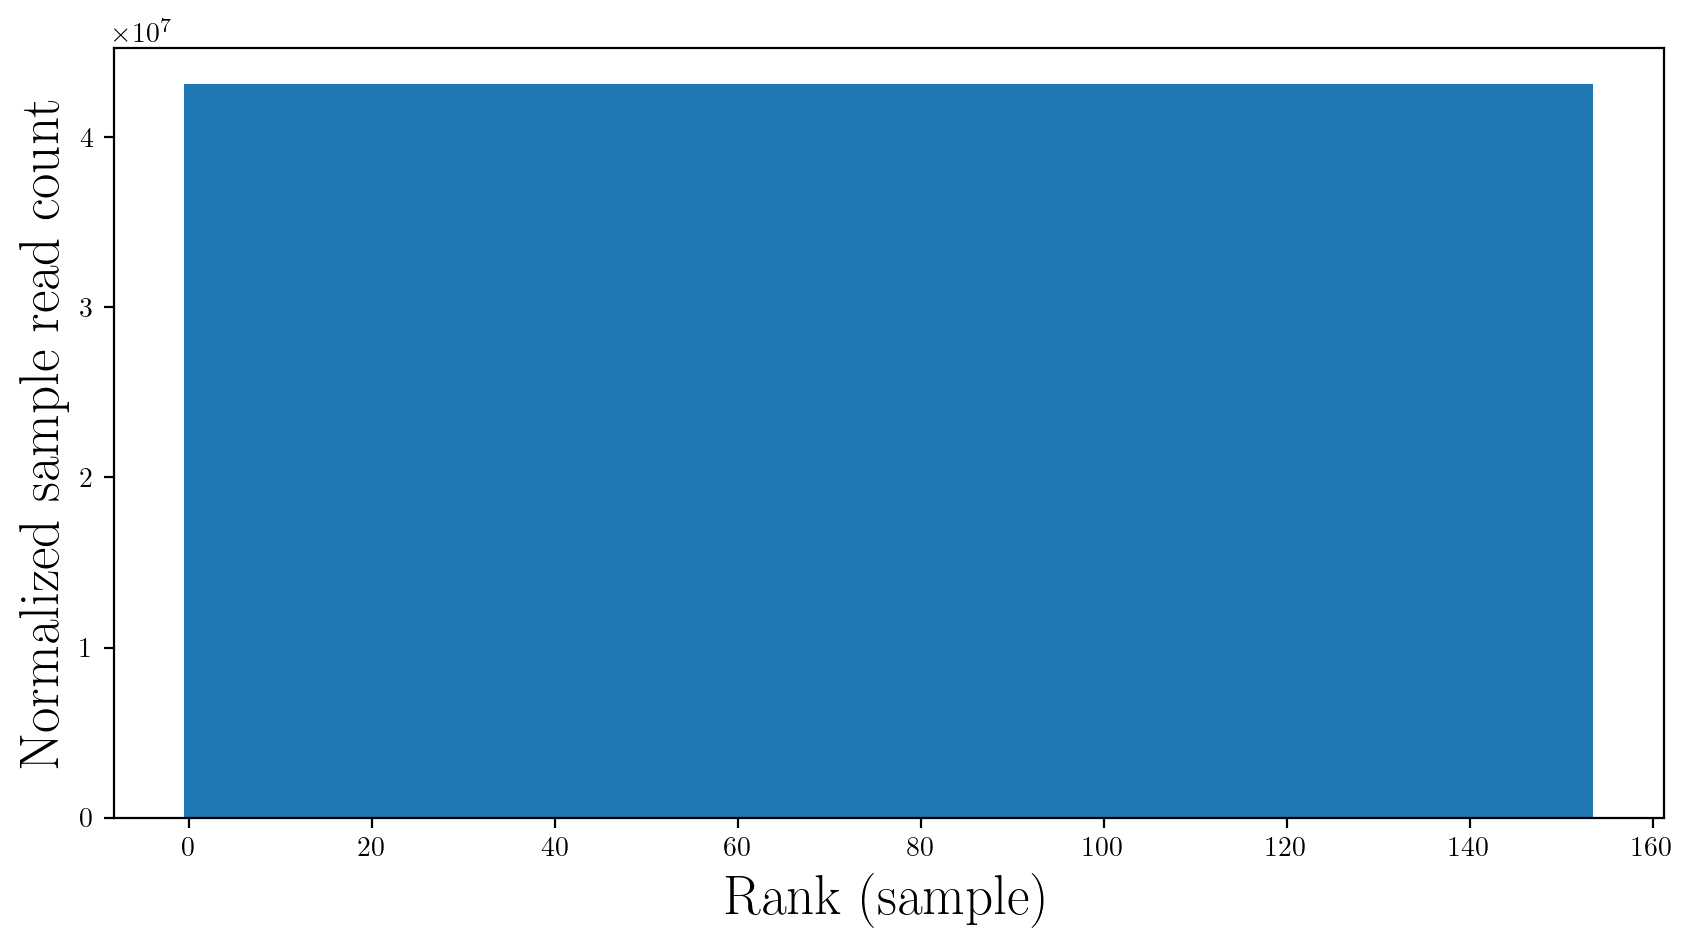

In [10]:
normalized_gene_sums = normalized_genes.sum(axis=0)

plt.figure(figsize=(10, 5), dpi=200)
plt.bar(range(sums.shape[0]), normalized_gene_sums.sort_values(ascending=False).values, width=1)
plt.ylabel("Normalized sample read count", fontsize=20)
plt.xlabel("Rank (sample)", fontsize=20)

In [11]:
log_trans = np.log(normalized_genes + 1)
log_trans

,TCGA-02-2483-01A-01R-1849-01,TCGA-02-2485-01A-01R-1849-01,TCGA-02-2486-01A-01R-1849-01,TCGA-06-0129-01A-01R-1849-01,TCGA-06-0178-01A-01R-1849-01,TCGA-06-0184-01A-01R-1849-01,TCGA-06-0644-01A-02R-1849-01,TCGA-06-0645-01A-01R-1849-01,TCGA-06-0646-01A-01R-1849-01,TCGA-06-0686-01A-01R-1849-01,...,TCGA-32-1980-01A-01R-1850-01,TCGA-32-2615-01A-01R-1850-01,TCGA-32-2616-01A-01R-1850-01,TCGA-32-2632-01A-01R-1850-01,TCGA-41-2571-01A-01R-1850-01,TCGA-41-2572-01A-01R-1850-01,TCGA-41-4097-01A-01R-1850-01,TCGA-76-4927-01A-01R-1850-01,TCGA-76-4928-01B-01R-1850-01,TCGA-76-4931-01A-01R-1850-01
1/2-SBSRNA4,3.845193,3.560805,3.356450,4.422751,5.185482,3.465509,3.741467,3.411446,4.669549,3.577645,...,3.641415,4.069551,3.050411,3.803364,4.422653,3.900065,4.328033,3.760411,3.759896,4.109896
A1BG,6.557582,5.070525,5.380694,5.802680,7.835071,5.546092,6.241800,6.070322,6.257798,6.447778,...,5.907255,6.653686,6.465729,5.361060,7.214260,7.223545,6.079533,5.985213,5.343265,4.664629
A1BG-AS1,3.845193,3.309678,3.318622,4.454125,4.118283,3.002835,3.699938,3.714929,4.244538,3.633250,...,4.429192,4.627777,4.314659,3.176803,4.743981,4.594755,4.383402,3.446465,2.877938,3.289166
A1CF,0.640488,0.681530,0.725077,1.513118,1.547827,0.647915,1.273262,1.083139,1.115616,2.217647,...,1.066403,1.444838,0.912551,0.714953,2.185311,1.195446,1.354993,0.894906,0.926334,1.045324
A2LD1,4.414783,5.745024,5.891639,4.746609,4.589712,5.517219,5.845610,5.197182,6.063210,5.532242,...,5.468942,5.418101,5.962483,6.116094,4.864066,6.261954,5.515036,5.853080,5.082334,5.639552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,7.939299,7.797480,7.200897,8.183099,7.690941,7.331615,7.207742,7.519984,7.811109,7.493157,...,7.914766,7.545934,7.657405,7.409565,7.721964,7.810447,7.568174,7.701079,7.476301,7.868437
ZYX,9.459216,9.433597,9.683462,9.252502,8.795059,9.796583,10.398582,10.300278,9.885456,9.931071,...,9.160233,9.487284,10.751785,9.248671,9.691337,10.466572,9.337074,9.819450,10.570606,9.847245
ZZEF1,7.601561,7.873563,7.162024,8.509158,6.548315,7.205903,7.530202,7.739730,8.431208,7.618322,...,7.671772,7.985312,7.550452,7.639518,8.328307,7.746776,8.223961,8.022440,7.747729,8.266574
ZZZ3,7.407160,7.391819,7.000127,7.925629,7.132513,7.079891,7.284742,6.971570,7.321117,7.136883,...,7.072581,7.344096,7.540605,6.953855,6.539929,6.795929,7.216485,7.159316,7.017458,7.230906


Text(0.5, 0, 'Log-transformed expression levels')

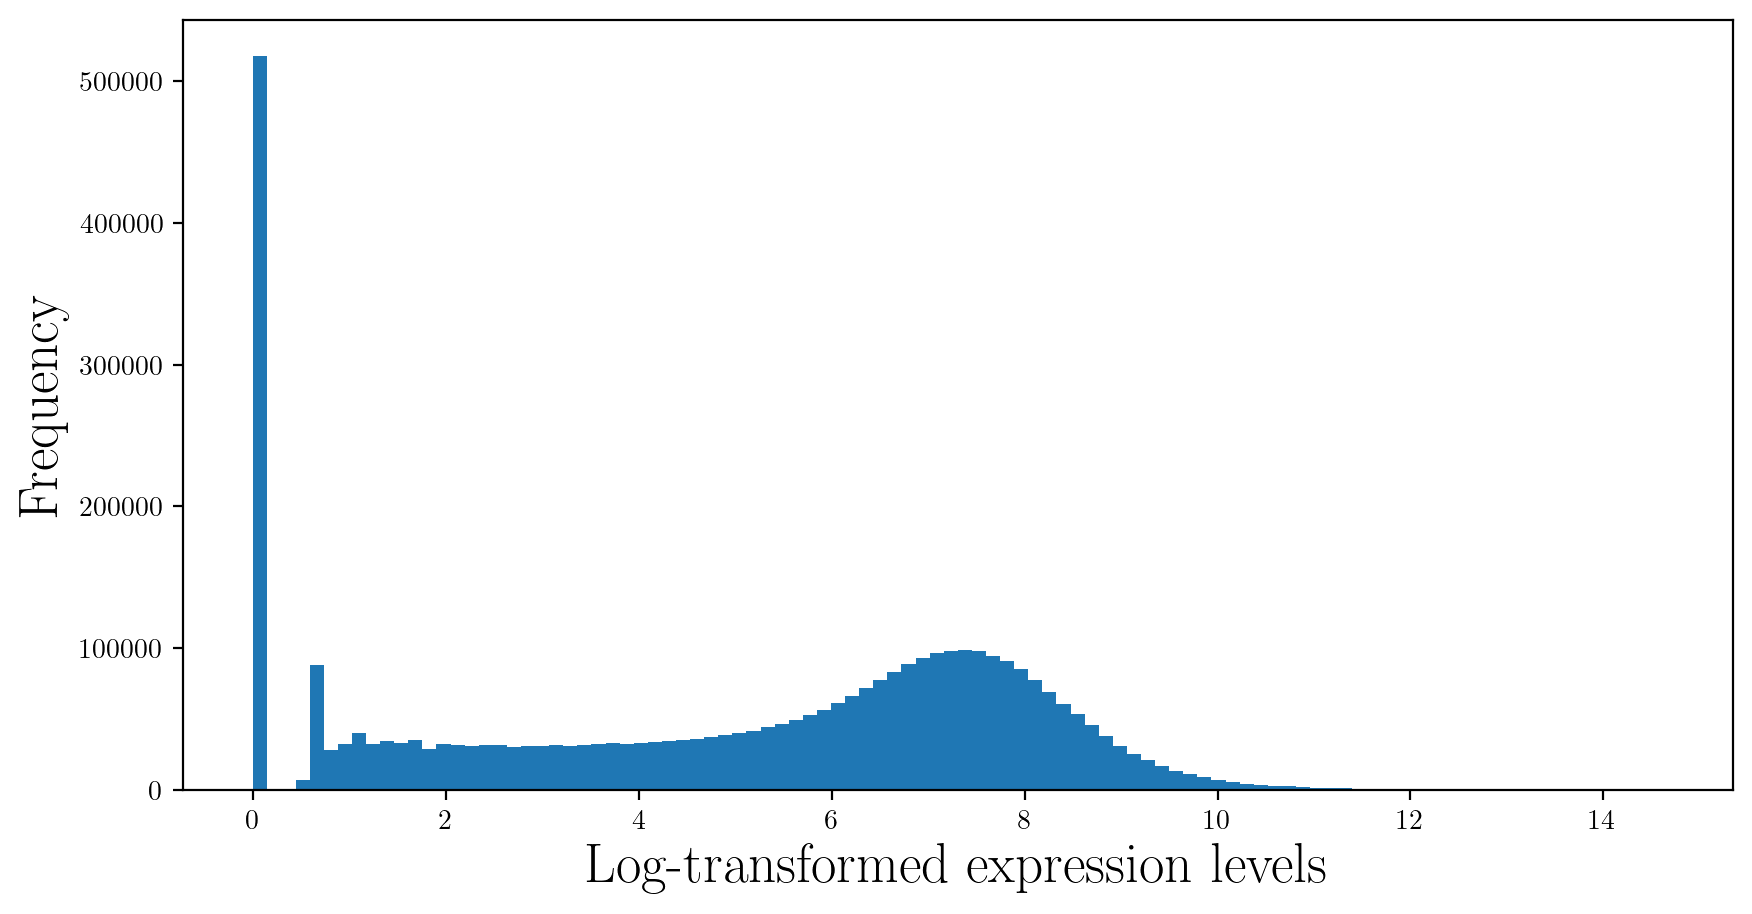

In [12]:
plt.figure(figsize=(10, 5), dpi=200)
plt.hist(log_trans.values.flatten(), bins=100)
plt.ylabel("Frequency", fontsize=20)
plt.xlabel("Log-transformed expression levels", fontsize=20)

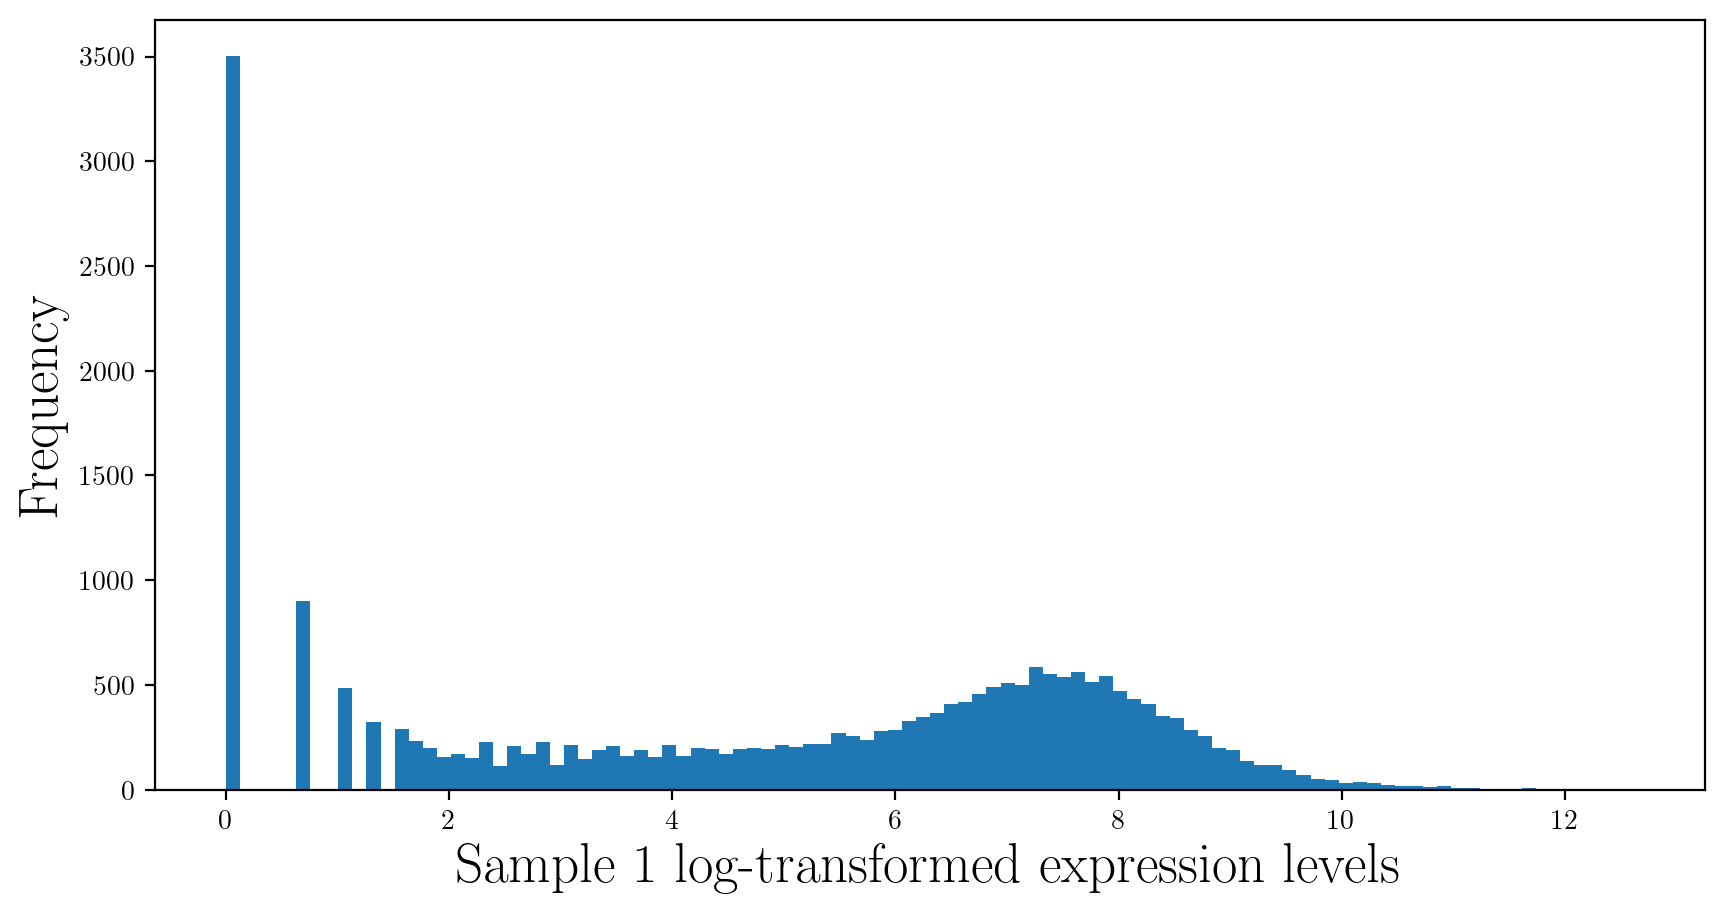

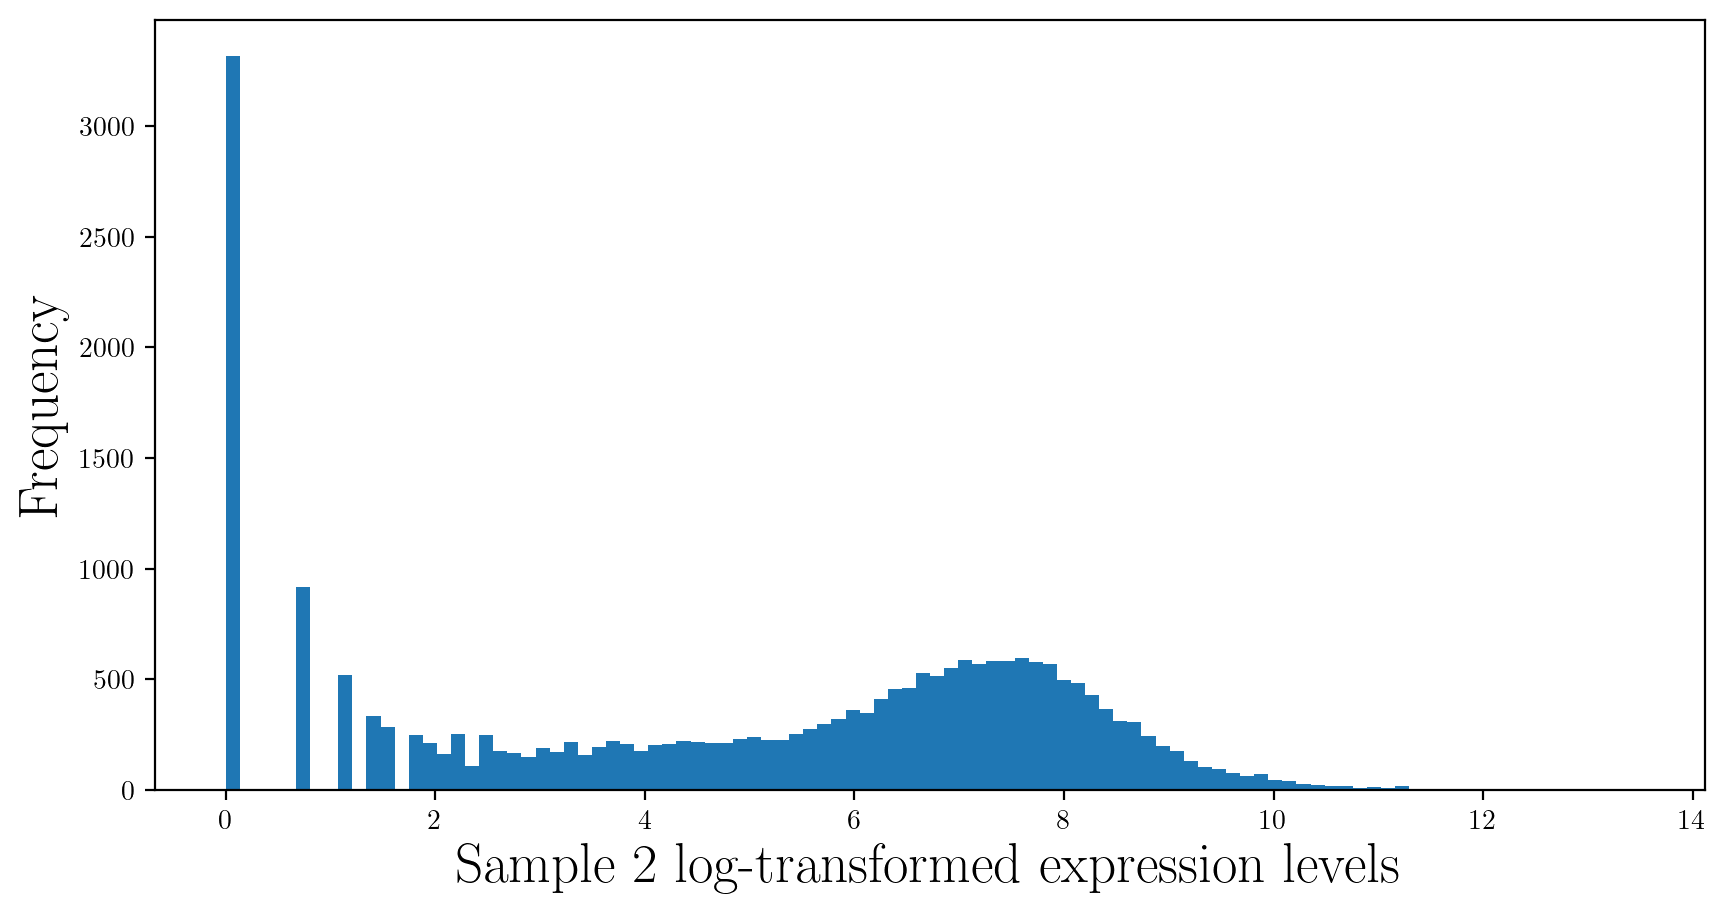

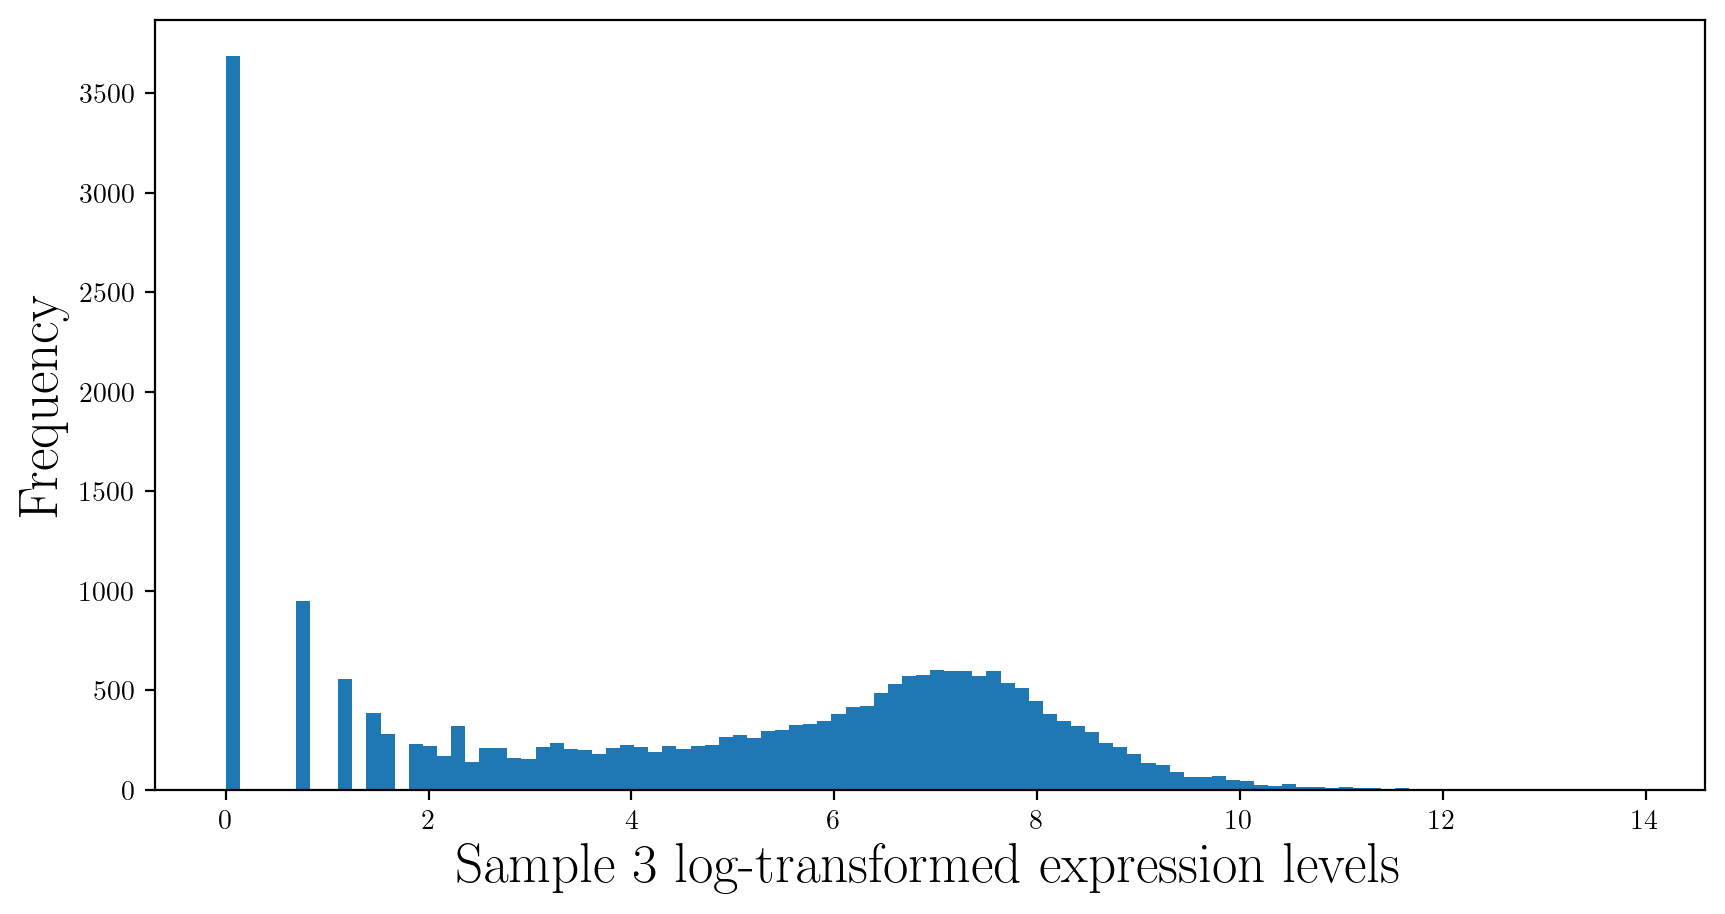

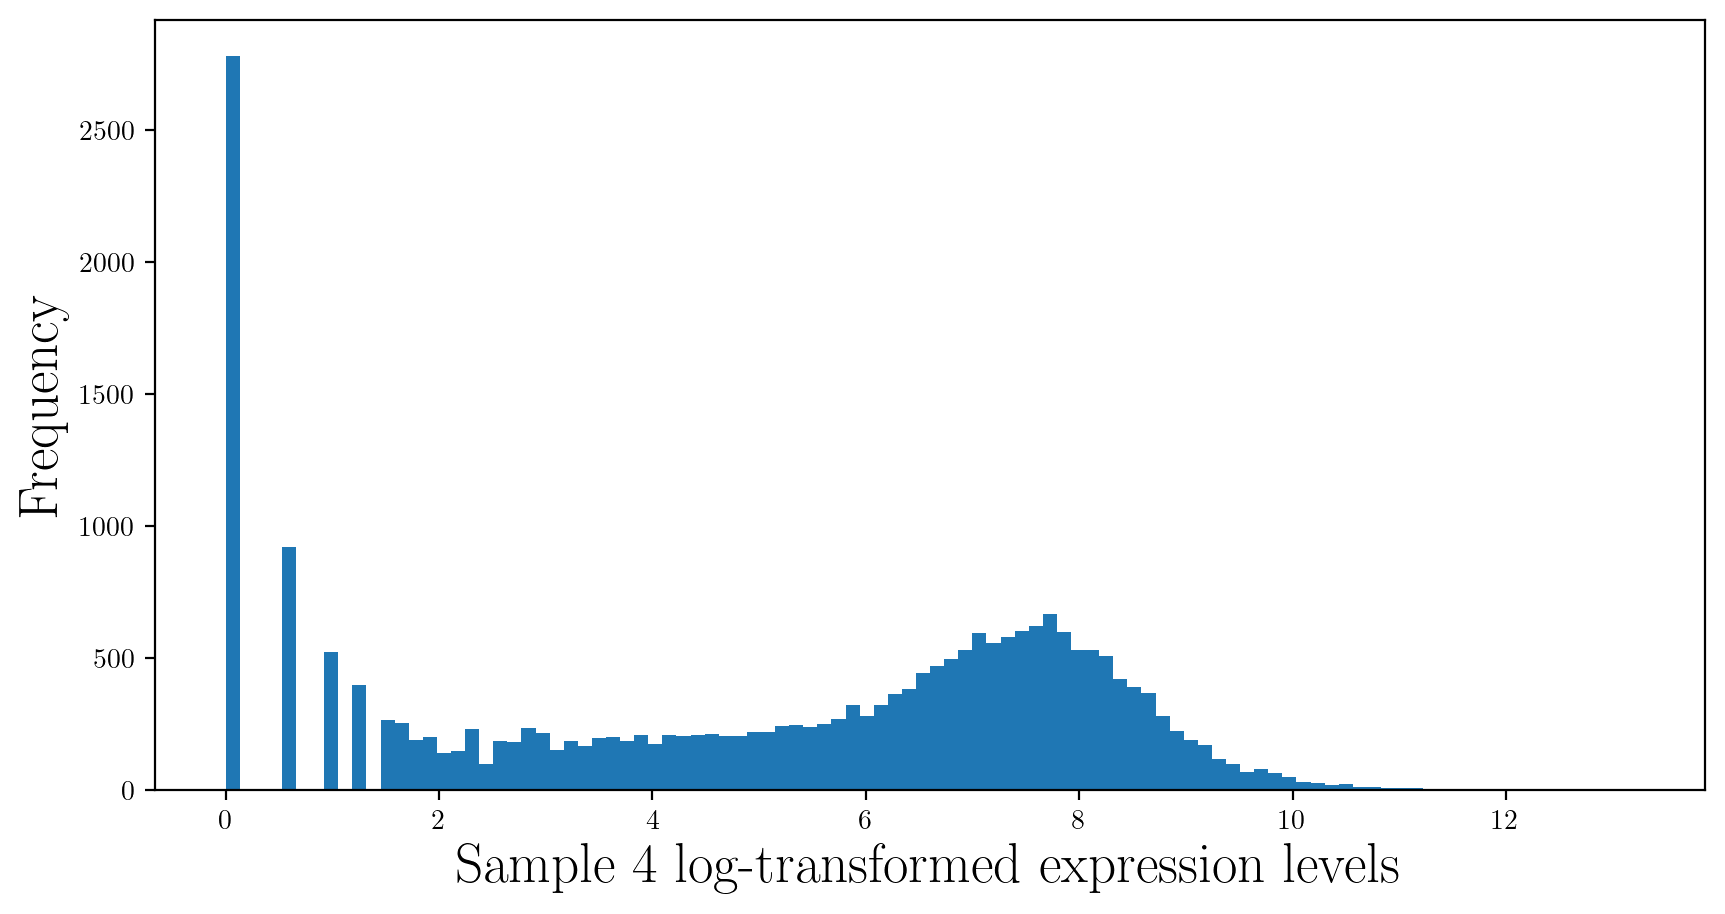

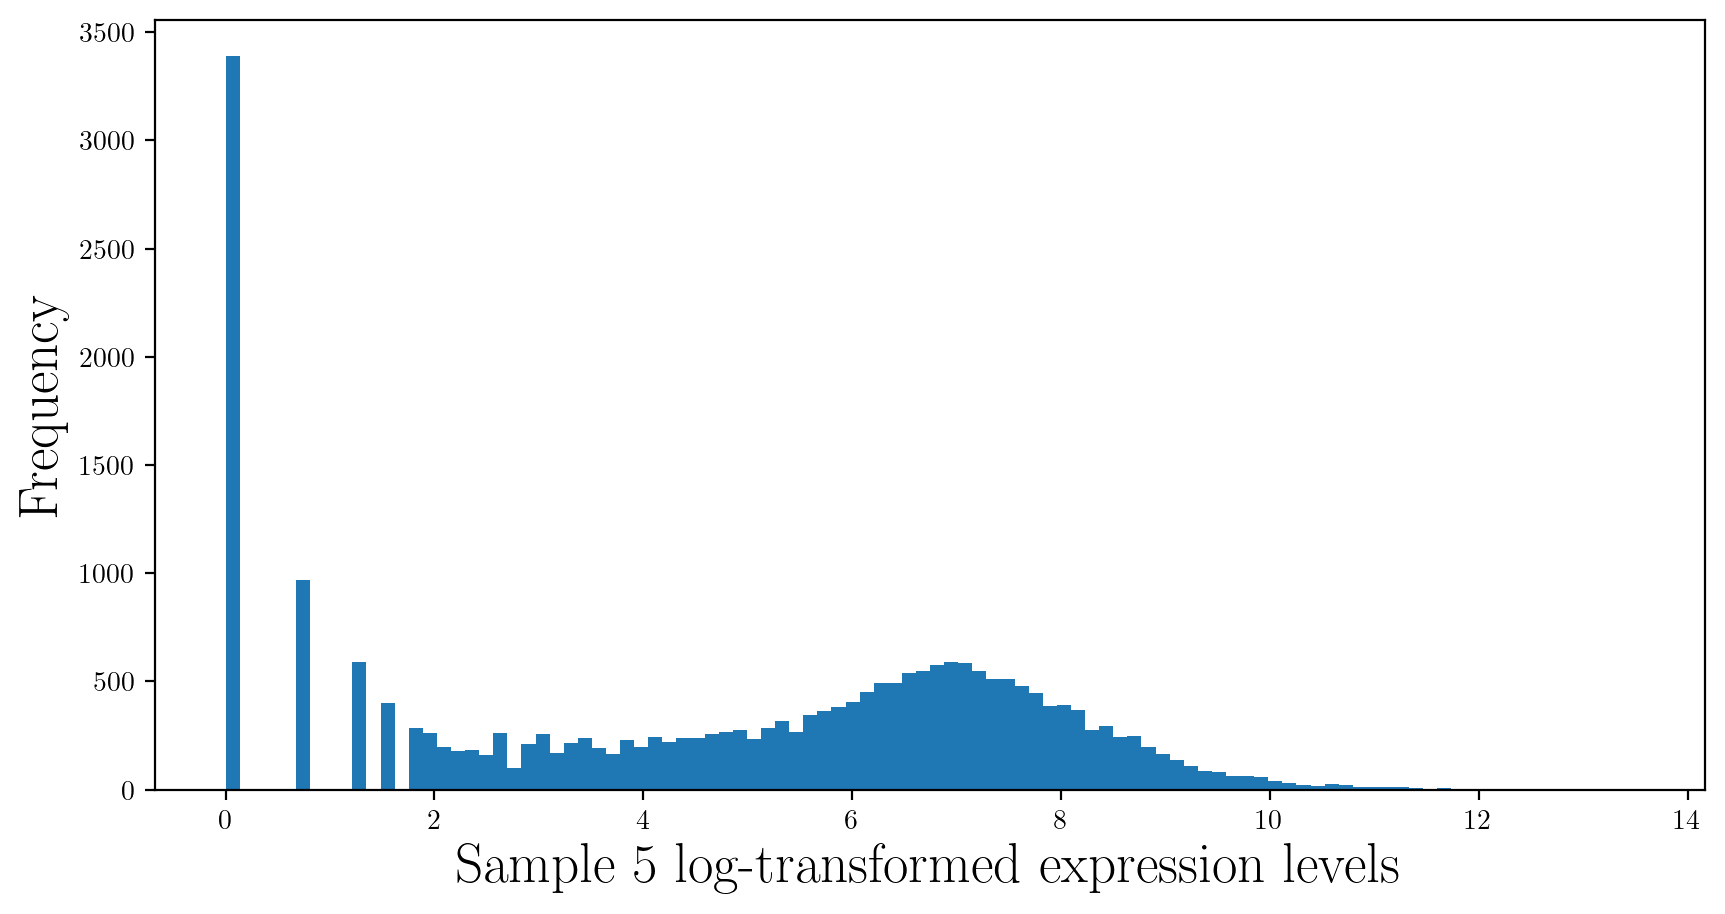

In [13]:
for i in range(5):
    curr_data = log_trans.iloc[:, i]
    
    plt.figure(figsize=(10, 5), dpi=200)
    plt.hist(curr_data.values.flatten(), bins=100)
    plt.ylabel("Frequency", fontsize=20)
    plt.xlabel(f"Sample {i + 1} log-transformed expression levels", fontsize=20)
    plt.show()

In [59]:
def quant(df):
    rank = np.argsort(np.argsort(df.values, axis=0), axis=0)
    
    transformed = np.zeros(df.shape)
    
    for r in tqdm(range(rank.max() + 1)):
        transformed[rank == r] = df.values[rank == r].mean()
        
    return pd.DataFrame(transformed, index=df.index, columns=df.columns)

In [60]:
df = pd.DataFrame({'C1': {'A': 5, 'B': 2, 'C': 3, 'D': 4},
                   'C2': {'A': 4, 'B': 1, 'C': 4, 'D': 2},
                   'C3': {'A': 3, 'B': 4, 'C': 6, 'D': 8}})
display(df)
display(quant(df))
display(qnorm.quantile_normalize(df, axis=1))

,C1,C2,C3
A,5,4,3
B,2,1,4
C,3,4,6
D,4,2,8


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11732.32it/s]


,C1,C2,C3
A,5.666667,4.666667,2.000000
B,2.000000,2.000000,3.000000
C,3.000000,5.666667,4.666667
D,4.666667,3.000000,5.666667


,C1,C2,C3
A,5.666667,5.166667,2.000000
B,2.000000,2.000000,3.000000
C,3.000000,5.166667,4.666667
D,4.666667,3.000000,5.666667


In [63]:
quantile_log_trans = quant(log_trans)
quantile_log_trans

100%|████████████████████████████████████████████████████████| 23368/23368 [02:19<00:00, 167.04it/s]


,TCGA-02-2483-01A-01R-1849-01,TCGA-02-2485-01A-01R-1849-01,TCGA-02-2486-01A-01R-1849-01,TCGA-06-0129-01A-01R-1849-01,TCGA-06-0178-01A-01R-1849-01,TCGA-06-0184-01A-01R-1849-01,TCGA-06-0644-01A-02R-1849-01,TCGA-06-0645-01A-01R-1849-01,TCGA-06-0646-01A-01R-1849-01,TCGA-06-0686-01A-01R-1849-01,...,TCGA-32-1980-01A-01R-1850-01,TCGA-32-2615-01A-01R-1850-01,TCGA-32-2616-01A-01R-1850-01,TCGA-32-2632-01A-01R-1850-01,TCGA-41-2571-01A-01R-1850-01,TCGA-41-2572-01A-01R-1850-01,TCGA-41-4097-01A-01R-1850-01,TCGA-76-4927-01A-01R-1850-01,TCGA-76-4928-01B-01R-1850-01,TCGA-76-4931-01A-01R-1850-01
1/2-SBSRNA4,4.000405,3.505639,3.656007,4.192972,5.395839,3.627474,4.123778,3.426654,4.281384,3.382797,...,3.312361,3.804238,3.301531,3.601361,4.227980,4.144985,3.962374,3.743365,3.972773,4.006245
A1BG,6.522247,5.034607,5.612631,5.572210,8.006490,5.656104,6.408198,6.090616,6.025838,6.396339,...,5.743653,6.582043,6.509527,5.273729,7.201496,7.283977,5.949210,5.967856,5.502514,4.580449
A1BG-AS1,4.004067,3.267396,3.607103,4.224261,4.232534,3.196761,4.080690,3.736262,3.856332,3.472128,...,4.102699,4.364834,4.544091,2.998904,4.571360,4.791940,4.030130,3.428247,3.118964,3.220613
A1CF,0.964612,0.906376,1.079039,1.184810,1.621327,0.516048,1.694440,1.017059,1.018911,1.878052,...,1.080932,1.198638,1.229192,0.863742,1.885143,1.210816,1.233027,1.179427,1.018911,1.093890
A2LD1,4.573742,5.673197,6.093562,4.524570,4.759694,5.628981,6.040280,5.192022,5.817464,5.393757,...,5.241074,5.202961,6.064149,6.096940,4.714516,6.363659,5.290614,5.831434,5.247128,5.543062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,7.885044,7.762929,7.351600,8.059036,7.881344,7.406062,7.294823,7.560024,7.741648,7.491496,...,7.905332,7.539529,7.626145,7.428008,7.703089,7.836261,7.558650,7.688130,7.532339,7.773260
ZYX,9.412406,9.398418,9.650296,9.276658,8.837580,9.773675,10.288209,10.326588,9.977470,9.911867,...,9.151535,9.540235,10.796056,9.249277,9.687413,10.379909,9.390689,9.796576,10.569152,9.884673
ZZEF1,7.536961,7.840430,7.313990,8.420659,6.798413,7.290845,7.598170,7.779445,8.398171,7.615673,...,7.662595,8.019607,7.525348,7.650946,8.291853,7.778943,8.242805,8.012579,7.785251,8.197308
ZZZ3,7.345413,7.353856,7.156141,7.792148,7.376950,7.164861,7.368824,7.006763,7.214798,7.116213,...,7.034688,7.325067,7.513513,6.970471,6.534536,6.859379,7.184928,7.152585,7.076348,7.138941


In [81]:
# check my implementation with other implementation
# import qnorm
# quantile_log_trans2 = qnorm.quantile_normalize(log_trans, axis=1)

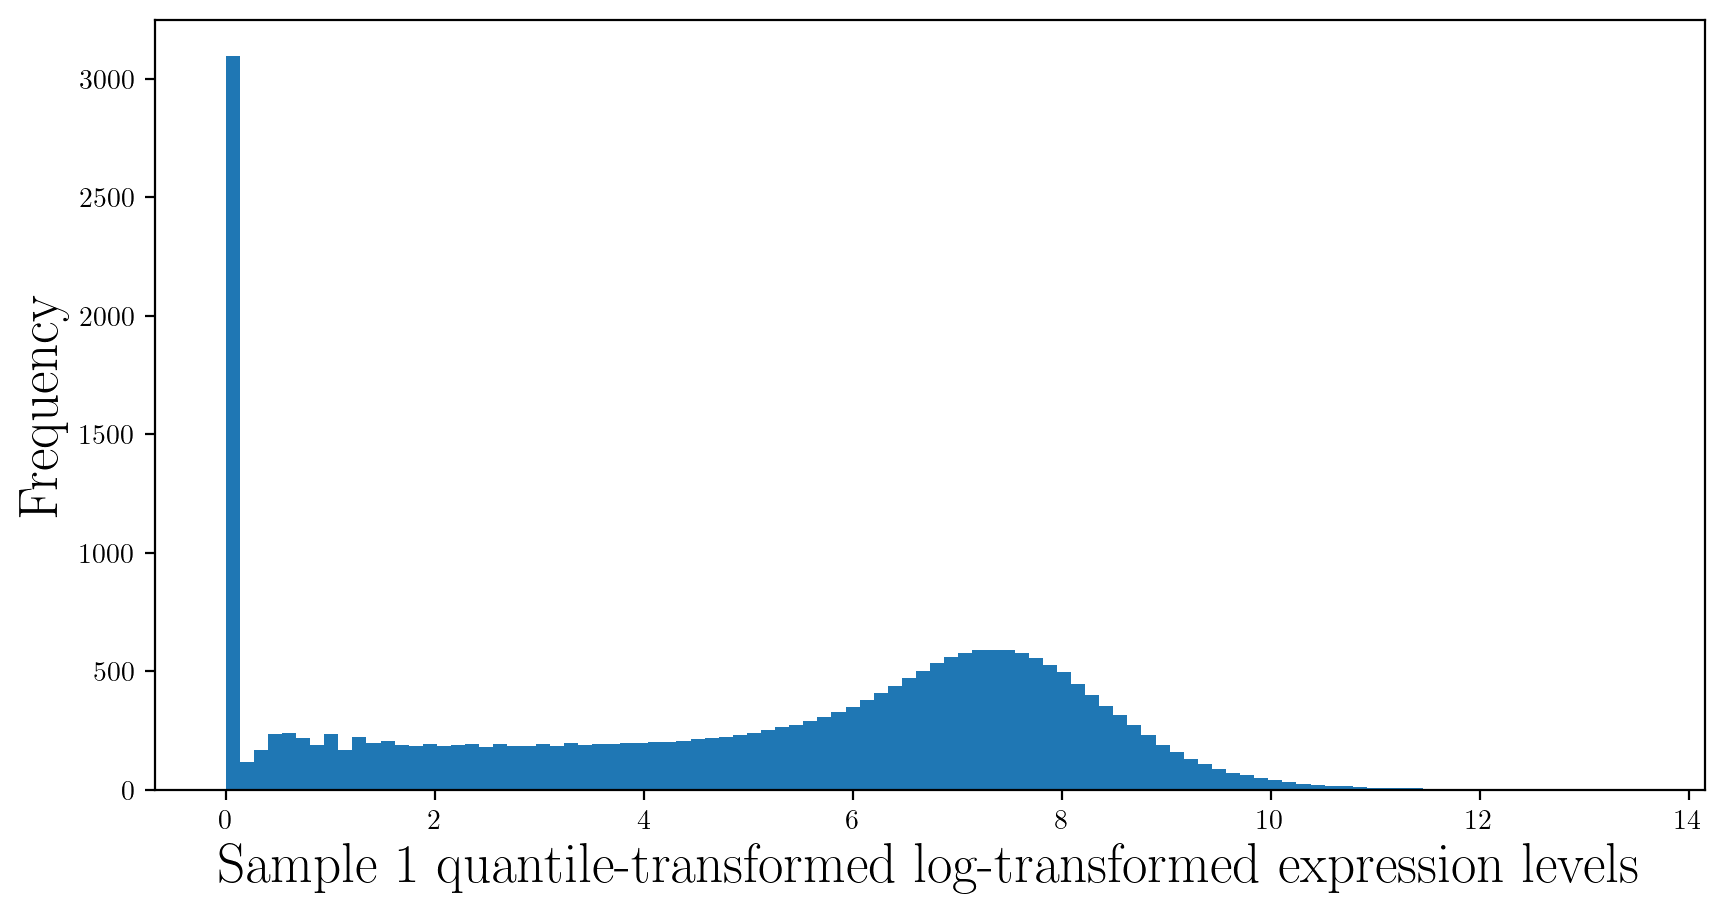

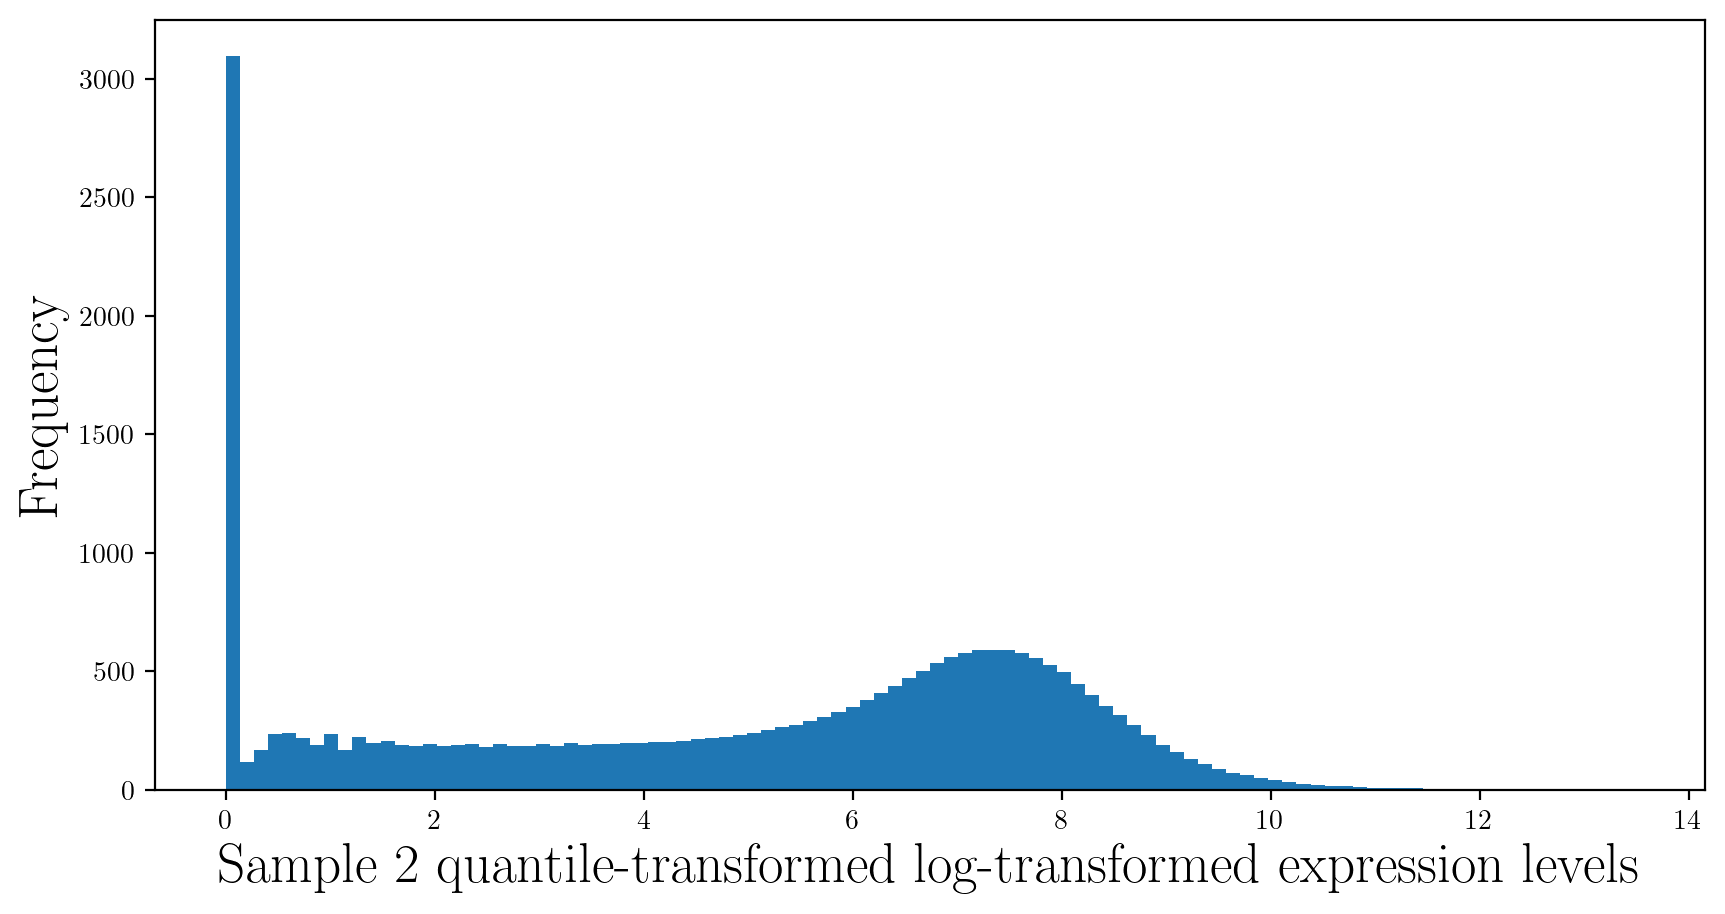

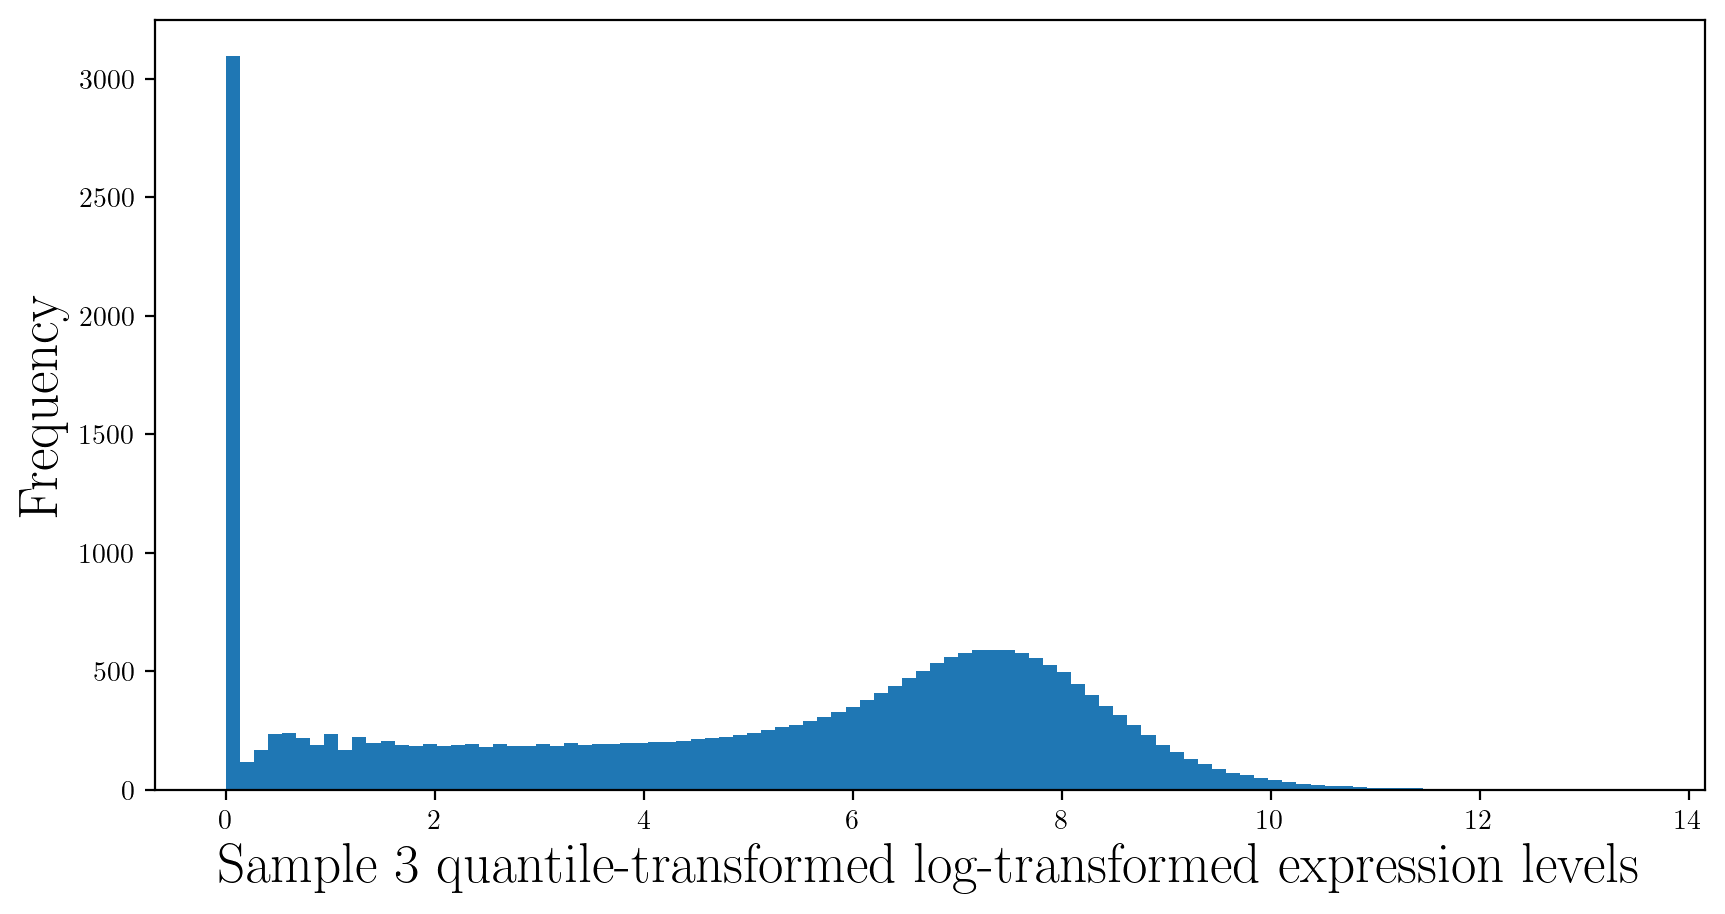

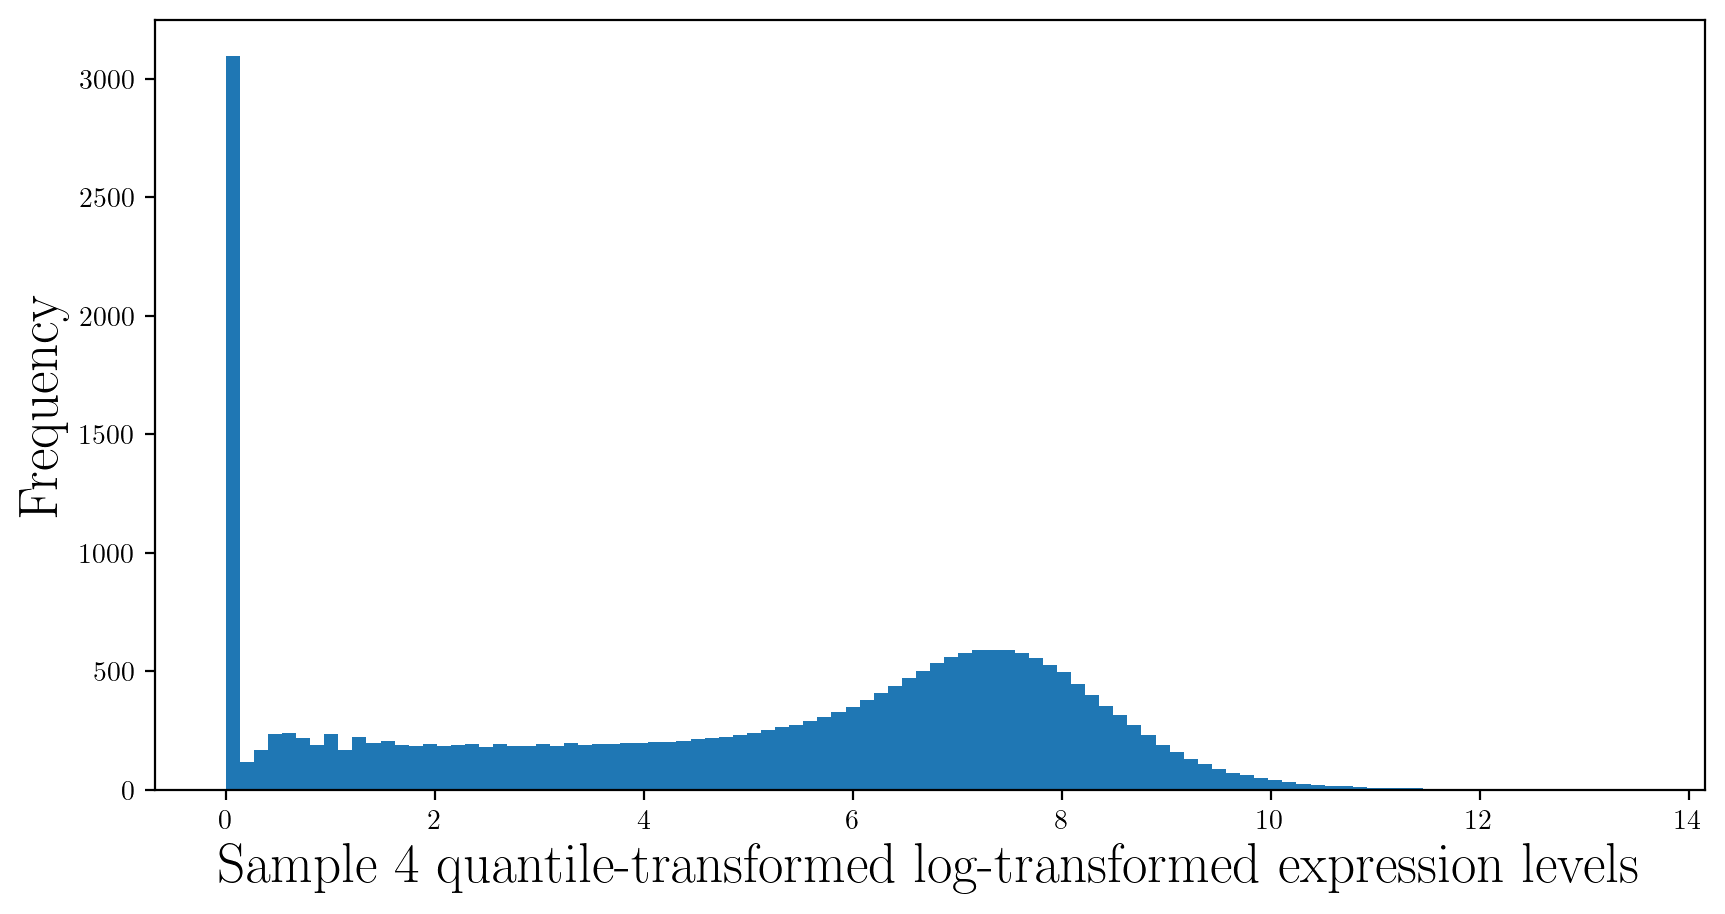

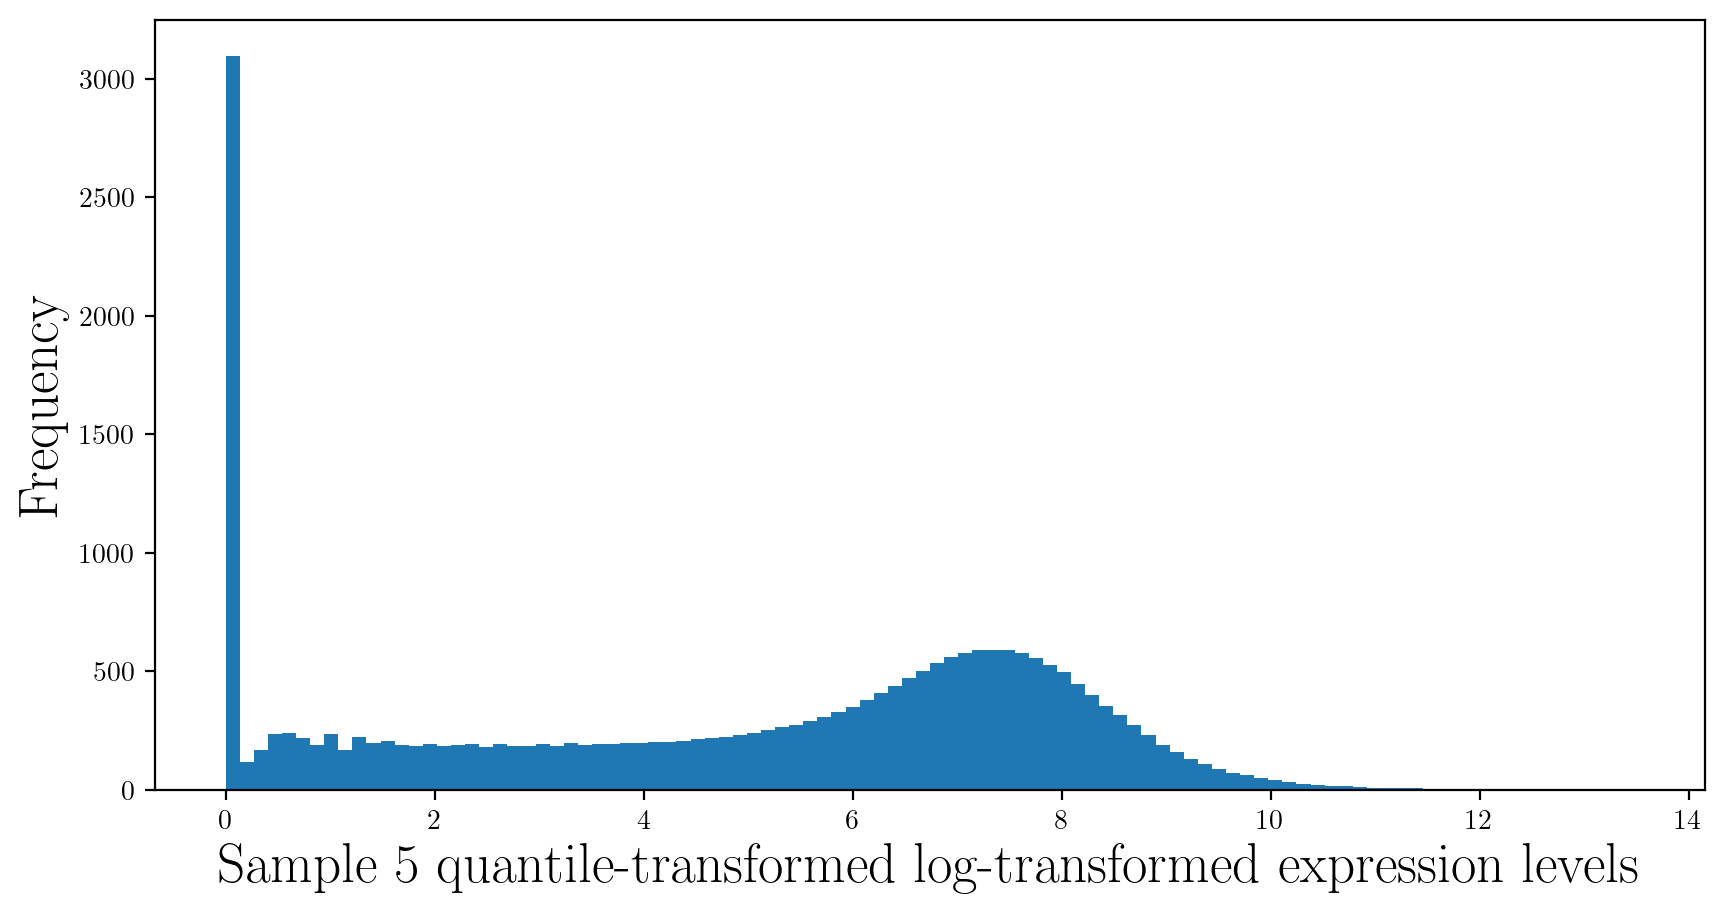

In [88]:
for i in range(5):
    curr_data = quantile_log_trans.iloc[:, i]
    
    plt.figure(figsize=(10, 5), dpi=200)
    plt.hist(curr_data.values.flatten(), bins=100)
    plt.ylabel("Frequency", fontsize=20)
    plt.xlabel(f"Sample {i + 1} quantile-transformed log-transformed expression levels", fontsize=20)
    plt.show()

# Analysis of differential expression

In [89]:
short = quantile_log_trans[outcomes[outcomes["Group"] == "short"].index]
long = quantile_log_trans[outcomes[outcomes["Group"] == "long"].index]
display(short)
long

,TCGA-02-2483-01A-01R-1849-01,TCGA-02-2485-01A-01R-1849-01,TCGA-02-2486-01A-01R-1849-01,TCGA-06-0129-01A-01R-1849-01,TCGA-06-0178-01A-01R-1849-01,TCGA-06-0184-01A-01R-1849-01,TCGA-06-0644-01A-02R-1849-01,TCGA-06-0645-01A-01R-1849-01,TCGA-06-0646-01A-01R-1849-01,TCGA-06-0686-01A-01R-1849-01,...,TCGA-32-2634-01A-01R-1850-01,TCGA-32-2638-01A-01R-1850-01,TCGA-32-4213-01A-01R-1850-01,TCGA-32-5222-01A-01R-1850-01,TCGA-41-3915-01A-01R-1850-01,TCGA-41-5651-01A-01R-1850-01,TCGA-76-4925-01A-01R-1850-01,TCGA-76-4926-01B-01R-1850-01,TCGA-76-4929-01A-01R-1850-01,TCGA-76-4932-01A-01R-1850-01
1/2-SBSRNA4,4.000405,3.505639,3.656007,4.192972,5.395839,3.627474,4.123778,3.426654,4.281384,3.382797,...,4.269156,3.699598,3.973092,3.982020,3.884596,3.542026,4.383566,4.005474,4.984945,4.060421
A1BG,6.522247,5.034607,5.612631,5.572210,8.006490,5.656104,6.408198,6.090616,6.025838,6.396339,...,6.134436,5.574157,6.952665,5.597075,6.365163,4.037725,3.996888,5.322409,6.107782,5.235720
A1BG-AS1,4.004067,3.267396,3.607103,4.224261,4.232534,3.196761,4.080690,3.736262,3.856332,3.472128,...,3.687459,3.712205,4.302098,2.956090,3.966865,2.100853,2.437177,3.279346,3.730690,1.937977
A1CF,0.964612,0.906376,1.079039,1.184810,1.621327,0.516048,1.694440,1.017059,1.018911,1.878052,...,0.688816,0.862209,0.900646,2.136792,0.971117,1.360838,1.191358,1.529184,2.214357,0.426871
A2LD1,4.573742,5.673197,6.093562,4.524570,4.759694,5.628981,6.040280,5.192022,5.817464,5.393757,...,3.535860,5.450523,5.895844,5.906059,4.923899,4.329467,5.810345,6.035126,3.764629,5.818810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,7.885044,7.762929,7.351600,8.059036,7.881344,7.406062,7.294823,7.560024,7.741648,7.491496,...,7.987612,7.641114,7.767917,8.007028,7.513720,7.843796,7.860682,7.929255,7.973013,8.013682
ZYX,9.412406,9.398418,9.650296,9.276658,8.837580,9.773675,10.288209,10.326588,9.977470,9.911867,...,9.004023,10.188632,9.441026,9.794510,9.715508,8.981085,10.135564,9.485692,8.892506,9.990140
ZZEF1,7.536961,7.840430,7.313990,8.420659,6.798413,7.290845,7.598170,7.779445,8.398171,7.615673,...,7.986537,7.936584,7.412431,7.044536,7.664695,7.483604,7.464486,7.837325,8.381996,7.574345
ZZZ3,7.345413,7.353856,7.156141,7.792148,7.376950,7.164861,7.368824,7.006763,7.214798,7.116213,...,7.581099,7.248032,7.213670,7.757472,7.430912,7.071283,7.637925,7.409152,7.274404,7.490373


,TCGA-02-0047-01A-01R-1849-01,TCGA-02-0055-01A-01R-1849-01,TCGA-06-0130-01A-01R-1849-01,TCGA-06-0132-01A-02R-1849-01,TCGA-06-0138-01A-02R-1849-01,TCGA-06-0139-01A-01R-1849-01,TCGA-06-0141-01A-01R-1849-01,TCGA-06-0152-02A-01R-2005-01,TCGA-06-0157-01A-01R-1849-01,TCGA-06-0158-01A-01R-1849-01,...,TCGA-32-1980-01A-01R-1850-01,TCGA-32-2615-01A-01R-1850-01,TCGA-32-2616-01A-01R-1850-01,TCGA-32-2632-01A-01R-1850-01,TCGA-41-2571-01A-01R-1850-01,TCGA-41-2572-01A-01R-1850-01,TCGA-41-4097-01A-01R-1850-01,TCGA-76-4927-01A-01R-1850-01,TCGA-76-4928-01B-01R-1850-01,TCGA-76-4931-01A-01R-1850-01
1/2-SBSRNA4,3.414740,3.415432,3.972023,3.361665,4.300189,4.184833,4.045431,2.997625,3.536193,3.766114,...,3.312361,3.804238,3.301531,3.601361,4.227980,4.144985,3.962374,3.743365,3.972773,4.006245
A1BG,5.697953,6.868927,5.940712,5.797646,6.371479,6.587140,6.904090,4.366435,4.533897,6.210741,...,5.743653,6.582043,6.509527,5.273729,7.201496,7.283977,5.949210,5.967856,5.502514,4.580449
A1BG-AS1,3.640417,3.839201,4.591474,3.495456,3.623894,3.681140,4.003173,3.171432,2.238808,4.668226,...,4.102699,4.364834,4.544091,2.998904,4.571360,4.791940,4.030130,3.428247,3.118964,3.220613
A1CF,0.299333,1.241235,0.000000,0.529106,1.195057,0.892409,0.775722,1.616759,0.727609,1.041075,...,1.080932,1.198638,1.229192,0.863742,1.885143,1.210816,1.233027,1.179427,1.018911,1.093890
A2LD1,4.764158,5.282464,5.191371,5.939334,5.683588,6.066852,5.827087,4.512771,5.699762,5.140688,...,5.241074,5.202961,6.064149,6.096940,4.714516,6.363659,5.290614,5.831434,5.247128,5.543062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,7.838567,7.594227,7.418966,8.063907,7.629096,7.450333,7.631201,7.732653,7.658108,7.772079,...,7.905332,7.539529,7.626145,7.428008,7.703089,7.836261,7.558650,7.688130,7.532339,7.773260
ZYX,9.164635,9.960486,10.282039,9.456220,9.520718,9.711602,9.683391,10.456790,9.848401,9.552868,...,9.151535,9.540235,10.796056,9.249277,9.687413,10.379909,9.390689,9.796576,10.569152,9.884673
ZZEF1,8.072442,7.271440,7.516709,7.467546,7.335804,7.632839,7.883029,8.104576,7.679877,7.984079,...,7.662595,8.019607,7.525348,7.650946,8.291853,7.778943,8.242805,8.012579,7.785251,8.197308
ZZZ3,7.205006,7.362692,7.576501,7.083117,7.126640,7.221895,7.336688,7.196648,7.201735,7.236052,...,7.034688,7.325067,7.513513,6.970471,6.534536,6.859379,7.184928,7.152585,7.076348,7.138941


In [90]:
wilc_info = []

for gene in tqdm(short.index):
    info = ranksums(short.loc[gene], long.loc[gene])
    stat, p = info.statistic, info.pvalue
    wilc_info.append({"p" : p, "stat" : stat, "gene" : gene})

100%|███████████████████████████████████████████████████████| 23368/23368 [00:13<00:00, 1704.16it/s]


In [91]:
wilc_info_df = pd.DataFrame(wilc_info)
wilc_info_df = wilc_info_df.set_index("gene")
wilc_info_df.sort_values("p")

,p,stat
gene,,
KCTD3,0.000004,4.620313
PRPF40A,0.000019,4.278804
CDC73,0.000020,4.267962
ATP6V1G2-DDX39B,0.000052,4.047517
TMEM191A,0.000068,-3.982468
...,...,...
CDY1,1.000000,0.000000
DKK2,1.000000,0.000000
IGBP1,1.000000,0.000000


In [92]:
deseq_results = pd.read_csv("HW1-DESEQ2.csv", index_col=0)
deseq_results.sort_values("pvalue")

,baseMean,log2FoldChange,lfcSE,stat,pvalue
MDM2,7415.433407,1.247112e+00,0.202847,6.148029,7.845182e-10
ZNF676,20.129594,-2.294866e+00,0.393419,-5.833136,5.439527e-09
TSHR,178.695858,-1.813284e+00,0.338058,-5.363822,8.147919e-08
LCE1C,4.589662,-2.218407e+00,0.414429,-5.352919,8.654682e-08
CAPSL,41.315338,-2.263032e+00,0.442399,-5.115360,3.131425e-07
...,...,...,...,...,...
RAB7A,15197.321038,1.353386e-05,0.053307,0.000254,9.997974e-01
TMEM48,1527.172383,-1.079268e-05,0.067746,-0.000159,9.998729e-01
ADAMTS4,1212.174019,7.233890e-06,0.178259,0.000041,9.999676e-01
SEPT7,20862.507600,-3.485183e-06,0.090848,-0.000038,9.999694e-01


In [93]:
deseq_results[deseq_results["pvalue"] < 0.05]

,baseMean,log2FoldChange,lfcSE,stat,pvalue
A2MP1,5.615631,-0.460540,0.196549,-2.343131,0.019123
AACS,990.593225,0.258326,0.067274,3.839919,0.000123
AASDH,629.966411,-0.207657,0.078671,-2.639574,0.008301
AATK,1142.016033,0.486404,0.211249,2.302519,0.021306
ABCA2,7608.961317,0.327225,0.147102,2.224470,0.026117
...,...,...,...,...,...
ZNHIT1,5243.741164,0.310900,0.116420,2.670507,0.007574
ZUFSP,377.036681,-0.192416,0.070690,-2.721958,0.006490
ZW10,740.069586,-0.150520,0.055732,-2.700784,0.006918
ZYG11A,9.882854,-0.539322,0.255851,-2.107953,0.035035


In [94]:
len(set(deseq_results[deseq_results["pvalue"] < 0.05].index) & set(wilc_info_df[wilc_info_df["p"] < 0.05].index))

1015

# Multiple hypothesis correction

In [95]:
deseq_results["bonferonni_corrected"] = deseq_results["pvalue"] * deseq_results.shape[0]
deseq_results

,baseMean,log2FoldChange,lfcSE,stat,pvalue,bonferonni_corrected
1/2-SBSRNA4,53.985205,-0.001698,0.114505,-0.014829,0.988169,22391.903190
A1BG,487.778127,0.260058,0.191434,1.358474,0.174313,3949.938451
A1BG-AS1,44.480071,0.169100,0.151216,1.118267,0.263453,5969.843171
A1CF,2.017838,0.139255,0.196477,0.708760,0.478474,10842.209589
A2LD1,237.717793,-0.138792,0.149799,-0.926520,0.354176,8025.624828
...,...,...,...,...,...,...
ZYG11B,2166.265279,0.037555,0.052813,0.711088,0.477030,10809.489592
ZYX,15860.378160,0.092256,0.120991,0.762509,0.445756,10100.831676
ZZEF1,2204.206060,-0.030773,0.092722,-0.331882,0.739978,16767.909899
ZZZ3,1384.817655,-0.173817,0.053616,-3.241868,0.001187,26.908515


In [96]:
deseq_results[deseq_results["bonferonni_corrected"] < 0.05].shape

(20, 6)

In [98]:
q = 0.05
sorted_deseq = deseq_results.sort_values("pvalue")
sorted_deseq

,baseMean,log2FoldChange,lfcSE,stat,pvalue,bonferonni_corrected
MDM2,7415.433407,1.247112e+00,0.202847,6.148029,7.845182e-10,0.000018
ZNF676,20.129594,-2.294866e+00,0.393419,-5.833136,5.439527e-09,0.000123
TSHR,178.695858,-1.813284e+00,0.338058,-5.363822,8.147919e-08,0.001846
LCE1C,4.589662,-2.218407e+00,0.414429,-5.352919,8.654682e-08,0.001961
CAPSL,41.315338,-2.263032e+00,0.442399,-5.115360,3.131425e-07,0.007096
...,...,...,...,...,...,...
RAB7A,15197.321038,1.353386e-05,0.053307,0.000254,9.997974e-01,22655.409762
TMEM48,1527.172383,-1.079268e-05,0.067746,-0.000159,9.998729e-01,22657.119637
ADAMTS4,1212.174019,7.233890e-06,0.178259,0.000041,9.999676e-01,22659.266295
SEPT7,20862.507600,-3.485183e-06,0.090848,-0.000038,9.999694e-01,22659.306398


In [103]:
m = sorted_deseq.shape[0]

sorted_deseq["threshold"] = np.arange(1, m + 1) * q / m
sorted_deseq

,baseMean,log2FoldChange,lfcSE,stat,pvalue,bonferonni_corrected,threshold
MDM2,7415.433407,1.247112e+00,0.202847,6.148029,7.845182e-10,0.000018,0.000002
ZNF676,20.129594,-2.294866e+00,0.393419,-5.833136,5.439527e-09,0.000123,0.000004
TSHR,178.695858,-1.813284e+00,0.338058,-5.363822,8.147919e-08,0.001846,0.000007
LCE1C,4.589662,-2.218407e+00,0.414429,-5.352919,8.654682e-08,0.001961,0.000009
CAPSL,41.315338,-2.263032e+00,0.442399,-5.115360,3.131425e-07,0.007096,0.000011
...,...,...,...,...,...,...,...
RAB7A,15197.321038,1.353386e-05,0.053307,0.000254,9.997974e-01,22655.409762,0.049991
TMEM48,1527.172383,-1.079268e-05,0.067746,-0.000159,9.998729e-01,22657.119637,0.049993
ADAMTS4,1212.174019,7.233890e-06,0.178259,0.000041,9.999676e-01,22659.266295,0.049996
SEPT7,20862.507600,-3.485183e-06,0.090848,-0.000038,9.999694e-01,22659.306398,0.049998


In [106]:
sorted_deseq[sorted_deseq["pvalue"] < sorted_deseq["threshold"]]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,bonferonni_corrected,threshold
MDM2,7415.433407,1.247112,0.202847,6.148029,7.845182e-10,0.000018,0.000002
ZNF676,20.129594,-2.294866,0.393419,-5.833136,5.439527e-09,0.000123,0.000004
TSHR,178.695858,-1.813284,0.338058,-5.363822,8.147919e-08,0.001846,0.000007
LCE1C,4.589662,-2.218407,0.414429,-5.352919,8.654682e-08,0.001961,0.000009
CAPSL,41.315338,-2.263032,0.442399,-5.115360,3.131425e-07,0.007096,0.000011
...,...,...,...,...,...,...,...
KRT19,14.158001,0.819628,0.237869,3.445706,5.695698e-04,12.906451,0.000574
RBPJL,3.438204,0.922204,0.267693,3.445004,5.710501e-04,12.939995,0.000576
DTX3,5779.199183,0.546019,0.158510,3.444693,5.717076e-04,12.954893,0.000578
MAP1LC3A,2115.158637,0.402718,0.116974,3.442784,5.757595e-04,13.046711,0.000580


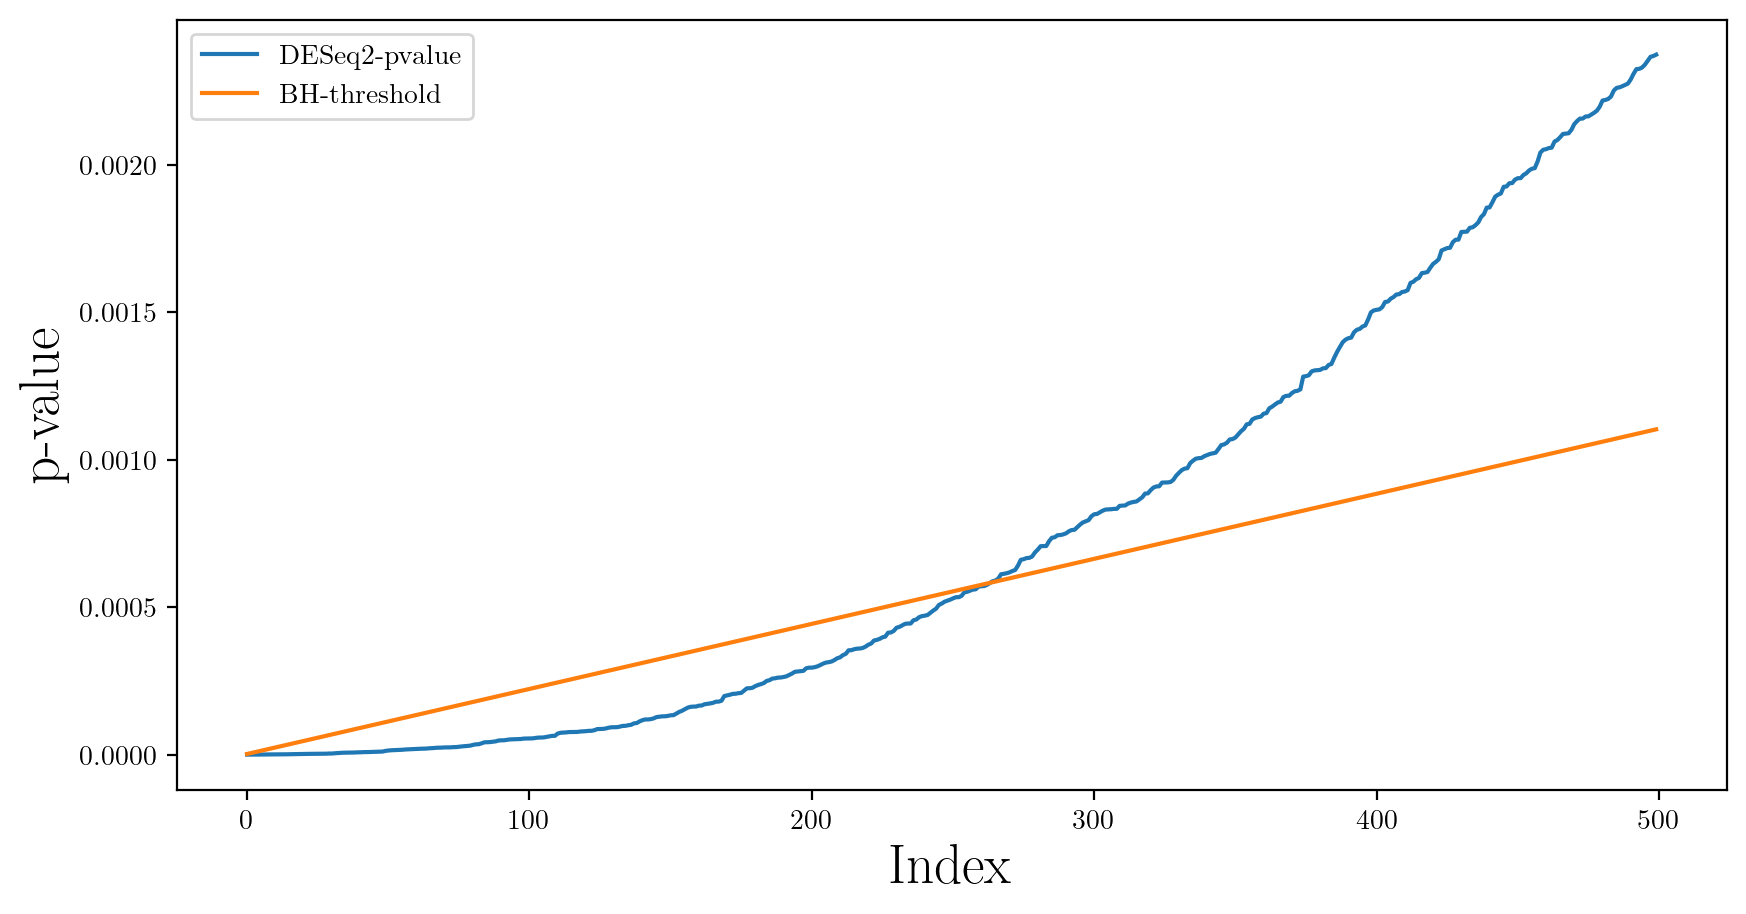

In [109]:
plt.figure(figsize=(10, 5), dpi=200)

plt.plot(range(500), sorted_deseq["pvalue"].iloc[:500], label="DESeq2-pvalue")
plt.plot(range(500), sorted_deseq["threshold"].iloc[:500], label="BH-threshold")
plt.xlabel("Index", fontsize=20)
plt.ylabel("p-value", fontsize=20)

plt.legend()

plt.show()